In [1]:
# Standard code libraries
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Custom code libraries from the ReSurfEMG
import resurfemg.helper_functions.helper_functions as hf
from resurfemg.postprocessing.baseline import moving_baseline
import resurfemg.preprocessing.envelope as evl
import resurfemg.postprocessing.event_detection as evt
import resurfemg.postprocessing.features as feat
import resurfemg.postprocessing.quality_assessment as qa

%matplotlib widget

In [2]:
# Define signal
fs_emg = 2048
t_emg = np.array([s_t/fs_emg for s_t in range(10*fs_emg)])
y_sin = np.cos((0.5* t_emg - 0.5)* 2 * np.pi)
y_sin[y_sin < 0] = 0
y_rand = np.random.normal(0, 1, size=len(y_sin))
y_rand_baseline = np.random.normal(0, 1, size=len(y_sin)) / 10
y_t = y_sin * y_rand + y_rand_baseline

# Get RMS signal
window_s = fs_emg // 5  # 200 ms --> Delay of 100 ms
y_env = evl.full_rolling_rms(y_t, window_s)
y_baseline = moving_baseline(y_env, 5*fs_emg, fs_emg//2)
peaks_s, _ = find_peaks(y_env, prominence=0.1)
_, starts_s, ends_s, *_ = evt.onoffpeak_baseline_crossing(
             y_env, y_baseline, peaks_s)

etps = feat.time_product(
    signal=y_env, fs=fs_emg, starts_s=starts_s, ends_s=ends_s)



In [3]:
# output = evaluate_bell_curve_error_loc(    
output = qa.evaluate_bell_curve_error(
    peaks_s=peaks_s,
    starts_s=starts_s,
    ends_s=ends_s,
    signal=y_env,
    fs=fs_emg,
    time_products=etps,
    bell_window_s=None,
    bell_threshold=40,
)
(valid_peak,
 bell_error,
 percentage_bell_error,
 y_mins,
 fitted_parameters) = output
valid_peak, bell_error, percentage_bell_error, y_mins, fitted_parameters

(array([ True,  True,  True,  True,  True]),
 array([0.04153165, 0.0400346 , 0.03384997, 0.03269618, 0.03975786]),
 array([6.0565936 , 5.66948109, 5.13783316, 4.71676279, 6.0831183 ]),
 array([0.07573662, 0.07573662, 0.07573662, 0.07424657, 0.07424657]),
 array([[0.95931015, 0.99503517, 0.36417484],
        [0.95558527, 3.00435122, 0.36517894],
        [0.92156411, 4.98927044, 0.3639297 ],
        [0.99885316, 7.00275512, 0.35549077],
        [0.91468414, 8.98973236, 0.36200804]]))

Text(0, 0.5, 'Signal (uV)')

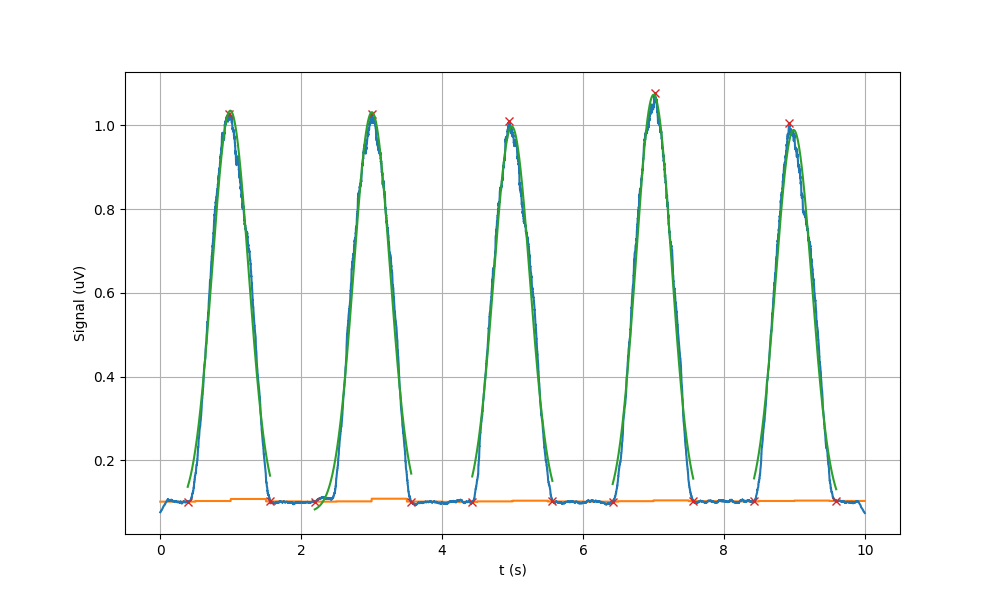

In [4]:
# Plot the raw data
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
axis.grid
axis.grid(True)
axis.plot(t_emg, y_baseline, color='tab:orange')
axis.plot(t_emg, y_env, color='tab:blue')
axis.plot(t_emg[peaks_s], y_env[peaks_s], 'x', color='tab:red')
axis.plot(t_emg[starts_s], y_env[starts_s], 'x', color='tab:red')
axis.plot(t_emg[ends_s], y_env[ends_s], 'x', color='tab:red')
for idx, (peak_s, start_i, end_i, y_min, p_set) in enumerate(
            zip(peaks_s, starts_s, ends_s, y_mins, fitted_parameters)):
    y_bell = hf.bell_curve(
        t_emg[start_i:end_i],
        a = p_set[0],
        b = p_set[1],
        c = p_set[2],
    )
    axis.plot(t_emg[start_i:end_i], y_min + y_bell, color='tab:green')

axis.set_xlabel('t (s)')
axis.set_ylabel('Signal (uV)')